In [1]:
import scanpy as sc
import os
import anndata as ad
import pandas as pd
import numpy as np
import gseapy as gp
import seaborn as sns
import matplotlib.pyplot as plt

import decoupler as dc

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


sc.settings.verbosity=0 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, facecolor="white", frameon=False, figsize=(4,4))
%matplotlib inline

 

In [2]:
from matplotlib import rcParams


rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42


# Load adata

In [3]:
#adata=sc.read_h5ad('/nfs/team298/ls34/disease_atlas/final_fb_adatas/adata_fbspericytesnonlesional_SCVI_3526_new_neighbor50_ANNOTATED_umap30_leiden_paga3_FINALcoreonly.h5ad.v4')
PATH = '/nfs/team298/ls34/fibroblast_atlas_paper/final_adatas/adata_healthy_core.h5ad'
adata=sc.read_h5ad(PATH)


In [4]:
sc.settings.figdir = "sfig2"
sc.settings.set_figure_params(dpi_save=300, facecolor="white", frameon=False, figsize=(17,17))

# Marker genes

In [5]:
adata.X[:6,:6].A

array([[0.        , 0.        , 0.51248444, 0.51248444, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.91178454, 0.        , 0.        ,
        0.        ],
       [0.58537907, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.39431788, 0.        , 0.39431788, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [6]:
adata

AnnData object with n_obs × n_vars = 165649 × 36601
    obs: 'sample_id', 'barcode', 'dataset_id', 'GSE', 'Site_status', 'Patient_status', 'DonorID', 'Location', 'Age', 'Sex', 'n_genes', 'OriginalAnnotation', 'Chemistry', 'lvl3_annotation', 'lvl2_annotation', 'lvl1_annotation', 'lvl0_annotation', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'QC_hi', 'QC_mid', 'leiden_res0.2', 'Site_status_binary', 'atlas_status_reynolds', 'atlas_status', 'Site_status2', 'Patient_status2', 'Sex_original', 'fb_vs_other', 'fb_vs_other2', 'core', 'fbs_pericytes_other', 'leiden_res1', 'leiden_res1.5', 'old_annotation', 'test', 'fbs', 'fbs2', 'fbs3', 'new_annotation3', 'new_annotation2', 'new_annotation1', 'new_annotation00', 'fb_status_figs', 'Location_original', 'Location_broad', 'Location_detailed', 'leiden_res0.5', '

In [7]:
adata.obs.corefb_names2.value_counts()

corefb_names2
F2: Universal         60120
F2/3: Perivascular    29376
F1: Superficial       27427
F4: DS_DPEP1+         19969
F3: FRC-like          19884
F4: TNN+COCH+          3604
F5: NGFR+              2769
F5: RAMP1+             1535
F4: DP_HHIP+            965
Name: count, dtype: int64

In [8]:
sc.tl.rank_genes_groups(adata, 'corefb_names2', method='t-test', key_added="rank_genes_groups");
df2 = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
df2.head(1)


F1: Superficial F2: Universal F2/3: Perivascular F3: FRC-like F4: DS_DPEP1+  \
0          COL6A1           DCN               APOD         APOE         POSTN   

  F4: TNN+COCH+ F4: DP_HHIP+ F5: RAMP1+ F5: NGFR+  
0          COCH         PTMA        CPE    TM4SF1

# GSEA

In [9]:
color_palettes = {
    'F1: Superficial': '#ffef5a',    'F2/3: Perivascular': '#364f99',
    'F2: Universal': '#91bae2',
    'F3: FRC-like': '#c6508f',
    'F4: DP_HHIP+': '#c9efb4',
    'F4: DS_DPEP1+': '#3d6f3b',
    'F4: TNN+COCH+': '#00f273',
    'F5: NGFR+': '#8981a7',
    'F5: RAMP1+': '#4b2657'
}


In [10]:
result = adata.uns['rank_genes_groups']
groups = list(df2.columns)
marker_genes = pd.DataFrame({group: result['names'][group] for group in groups})
marker_genes


F1: Superficial F2: Universal F2/3: Perivascular F3: FRC-like  \
0              COL6A1           DCN               APOD         APOE   
1             COL18A1         FBLN1               APOE        CCL19   
2                 CD9          CCN5               FGF7       IGFBP7   
3              APCDD1        CTHRC1             IGFBP7       CXCL12   
4              COL6A2        S100A6                MGP        HLA-B   
...               ...           ...                ...          ...   
36596            GPX3       COL18A1             APCDD1          CPE   
36597          CHRDL1        COL4A1               WIF1       CTHRC1   
36598          IGFBP6         PTGDS                CD9         MMP2   
36599          CXCL12       SPARCL1              F13A1       IGFBP6   
36600             MGP          APOE               AQP1        MFAP5   

      F4: DS_DPEP1+ F4: TNN+COCH+ F4: DP_HHIP+ F5: RAMP1+ F5: NGFR+  
0             POSTN          COCH         PTMA        CPE    TM4SF1  
1               F2R          ASPN        INHBA       APOD    CYP1B1  
2           COL11A1       SPARCL1        WNT5A      SFRP1    IGFBP7  
3              ASPN           OGN       IGFBP3     FGFBP2     TAGLN  
4              GPC3           TNN        TRPS1    OLFML2A     NR2F2  
...             ...           ...          ...        ...       ...  
36596           CLU          APOD      ANGPTL1       PDPN     FBLN1  
36597        SCARA5        EFEMP1       CXCL12         CP     ROBO2  
36598         ADIRF            C3        ADH1B       CA12     MFAP4  
36599          CCN5         SFRP2         CCN5     CTHRC1       DPT  
36600         MGST1           MGP           C3       WIF1      CCN5  

[36601 rows x 9 columns]

In [11]:
gsea_results = []

for cluster in marker_genes.columns:
    gene_list = marker_genes[cluster].tolist()
    enr = gp.enrichr(gene_list=gene_list[:500],
                     gene_sets= 'GO_Biological_Process_2023',  # You can choose other gene sets here
                     outdir=None,  # Set to None to avoid creating output files
                     cutoff=0.05  # Cutoff for statistical significance
                    )
    enr.results['Cluster'] = cluster
    gsea_results.append(enr.results)

gsea_df = pd.concat(gsea_results)
gsea_df
"""
Reactome_2019 
'KEGG_2016',
'Reactome_2019',
'GO_Biological_Process_2018''GO_Cellular_Component_2018''GO_Molecular_Function_2018'
"""


"\nReactome_2019 \n'KEGG_2016',\n'Reactome_2019',\n'GO_Biological_Process_2018''GO_Cellular_Component_2018''GO_Molecular_Function_2018'\n"

In [12]:
gsea_df.columns

Index(['Gene_set', 'Term', 'Overlap', 'P-value', 'Adjusted P-value',
       'Old P-value', 'Old Adjusted P-value', 'Odds Ratio', 'Combined Score',
       'Genes', 'Cluster'],
      dtype='object')

/tmp/ipykernel_19142/481244881.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_gsea_df = gsea_df.groupby('Cluster').apply(lambda x: x.nlargest(5, PLOTTING_VALUE)).reset_index(drop=True)


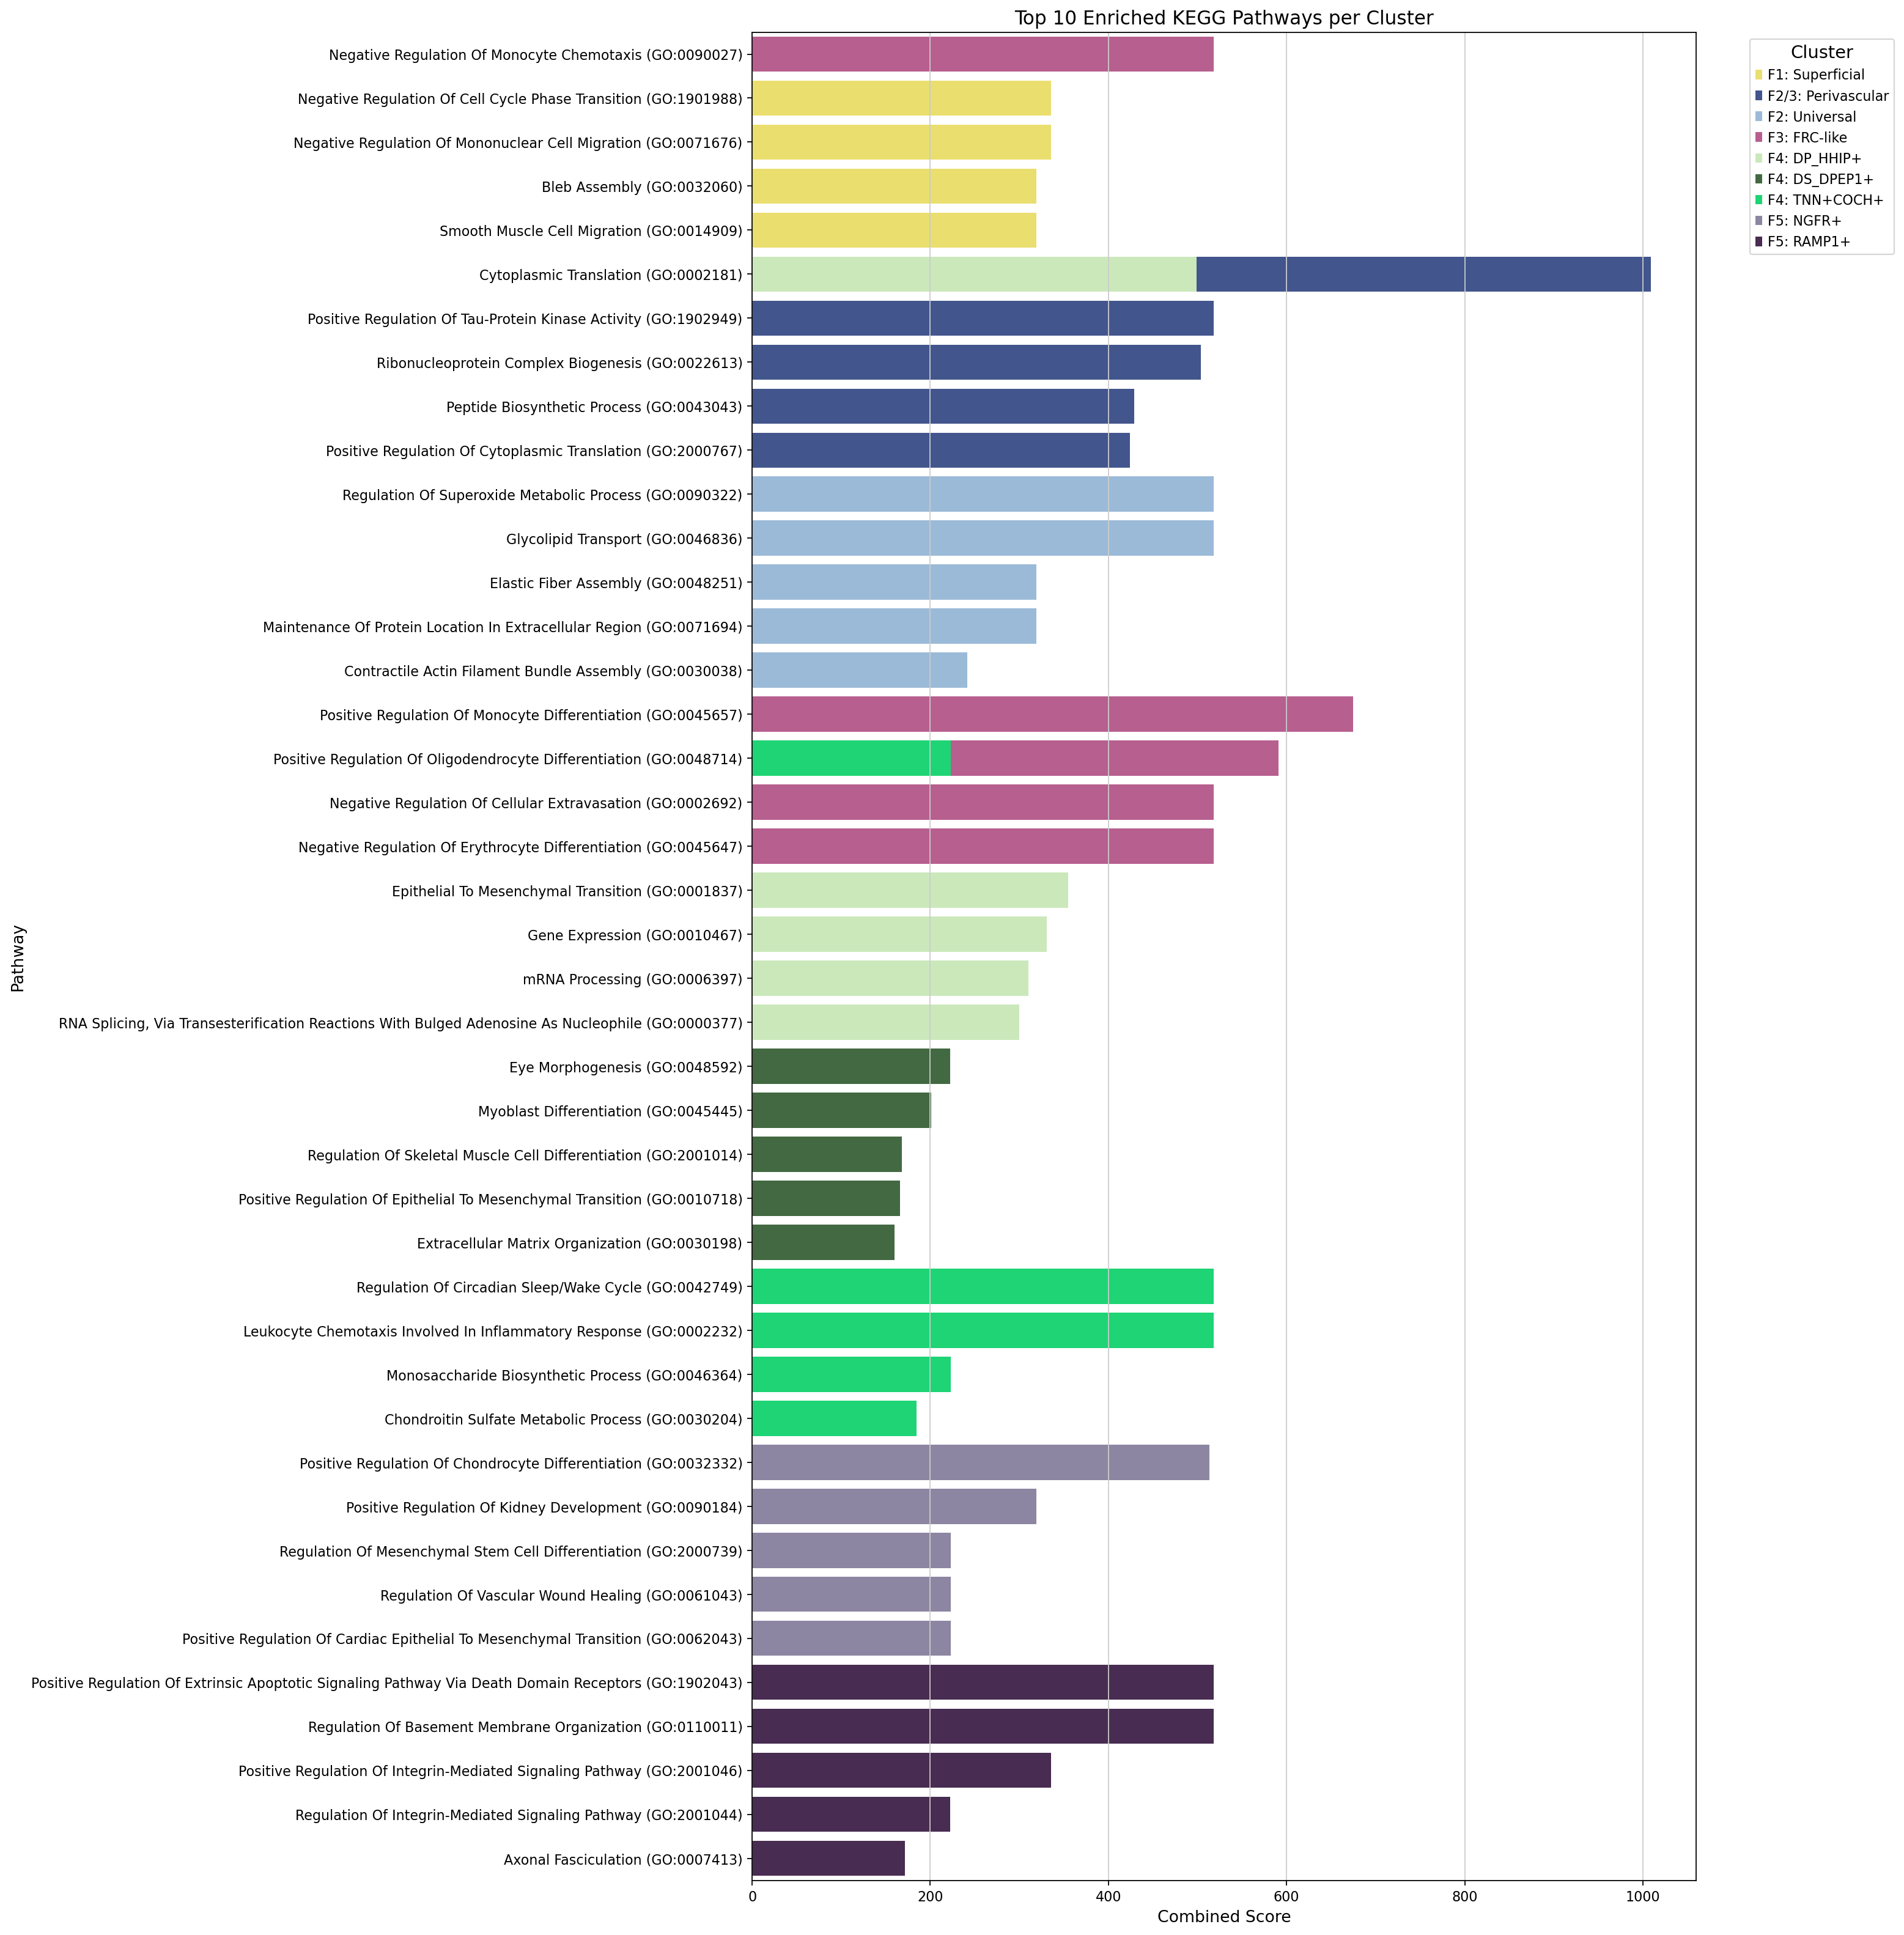

In [13]:
PLOTTING_VALUE = 'Combined Score' #'Adjusted P-value' #'Combined Score'


top_gsea_df = gsea_df.groupby('Cluster').apply(lambda x: x.nlargest(5, PLOTTING_VALUE)).reset_index(drop=True)


top_gsea_df = top_gsea_df.sort_values(by=['Cluster', PLOTTING_VALUE], ascending=[True, False])


cluster_colors = top_gsea_df['Cluster'].map(color_palettes)


plt.figure(figsize=(20, 20))
sns.barplot(x=PLOTTING_VALUE, y='Term', hue='Cluster', data=top_gsea_df, palette=color_palettes, dodge=False)
plt.title('Top 10 Enriched KEGG Pathways per Cluster', fontsize=14)
plt.xlabel(PLOTTING_VALUE, fontsize=12)
plt.ylabel('Pathway', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize='13')
plt.tight_layout()
plt.show()

In [14]:
ORDER = ['F1: Superficial', 'F2: Universal',  'F2/3: Perivascular',  'F3: FRC-like', 'F4: DS_DPEP1+', 'F4: TNN+COCH+','F5: NGFR+', 'F4: DP_HHIP+', 'F5: RAMP1+']


/tmp/ipykernel_19142/3512306357.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_gsea_df = gsea_df.groupby('Cluster').apply(lambda x: x.nlargest(35, PLOTTING_VALUE)).reset_index(drop=True)
/tmp/ipykernel_19142/3512306357.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


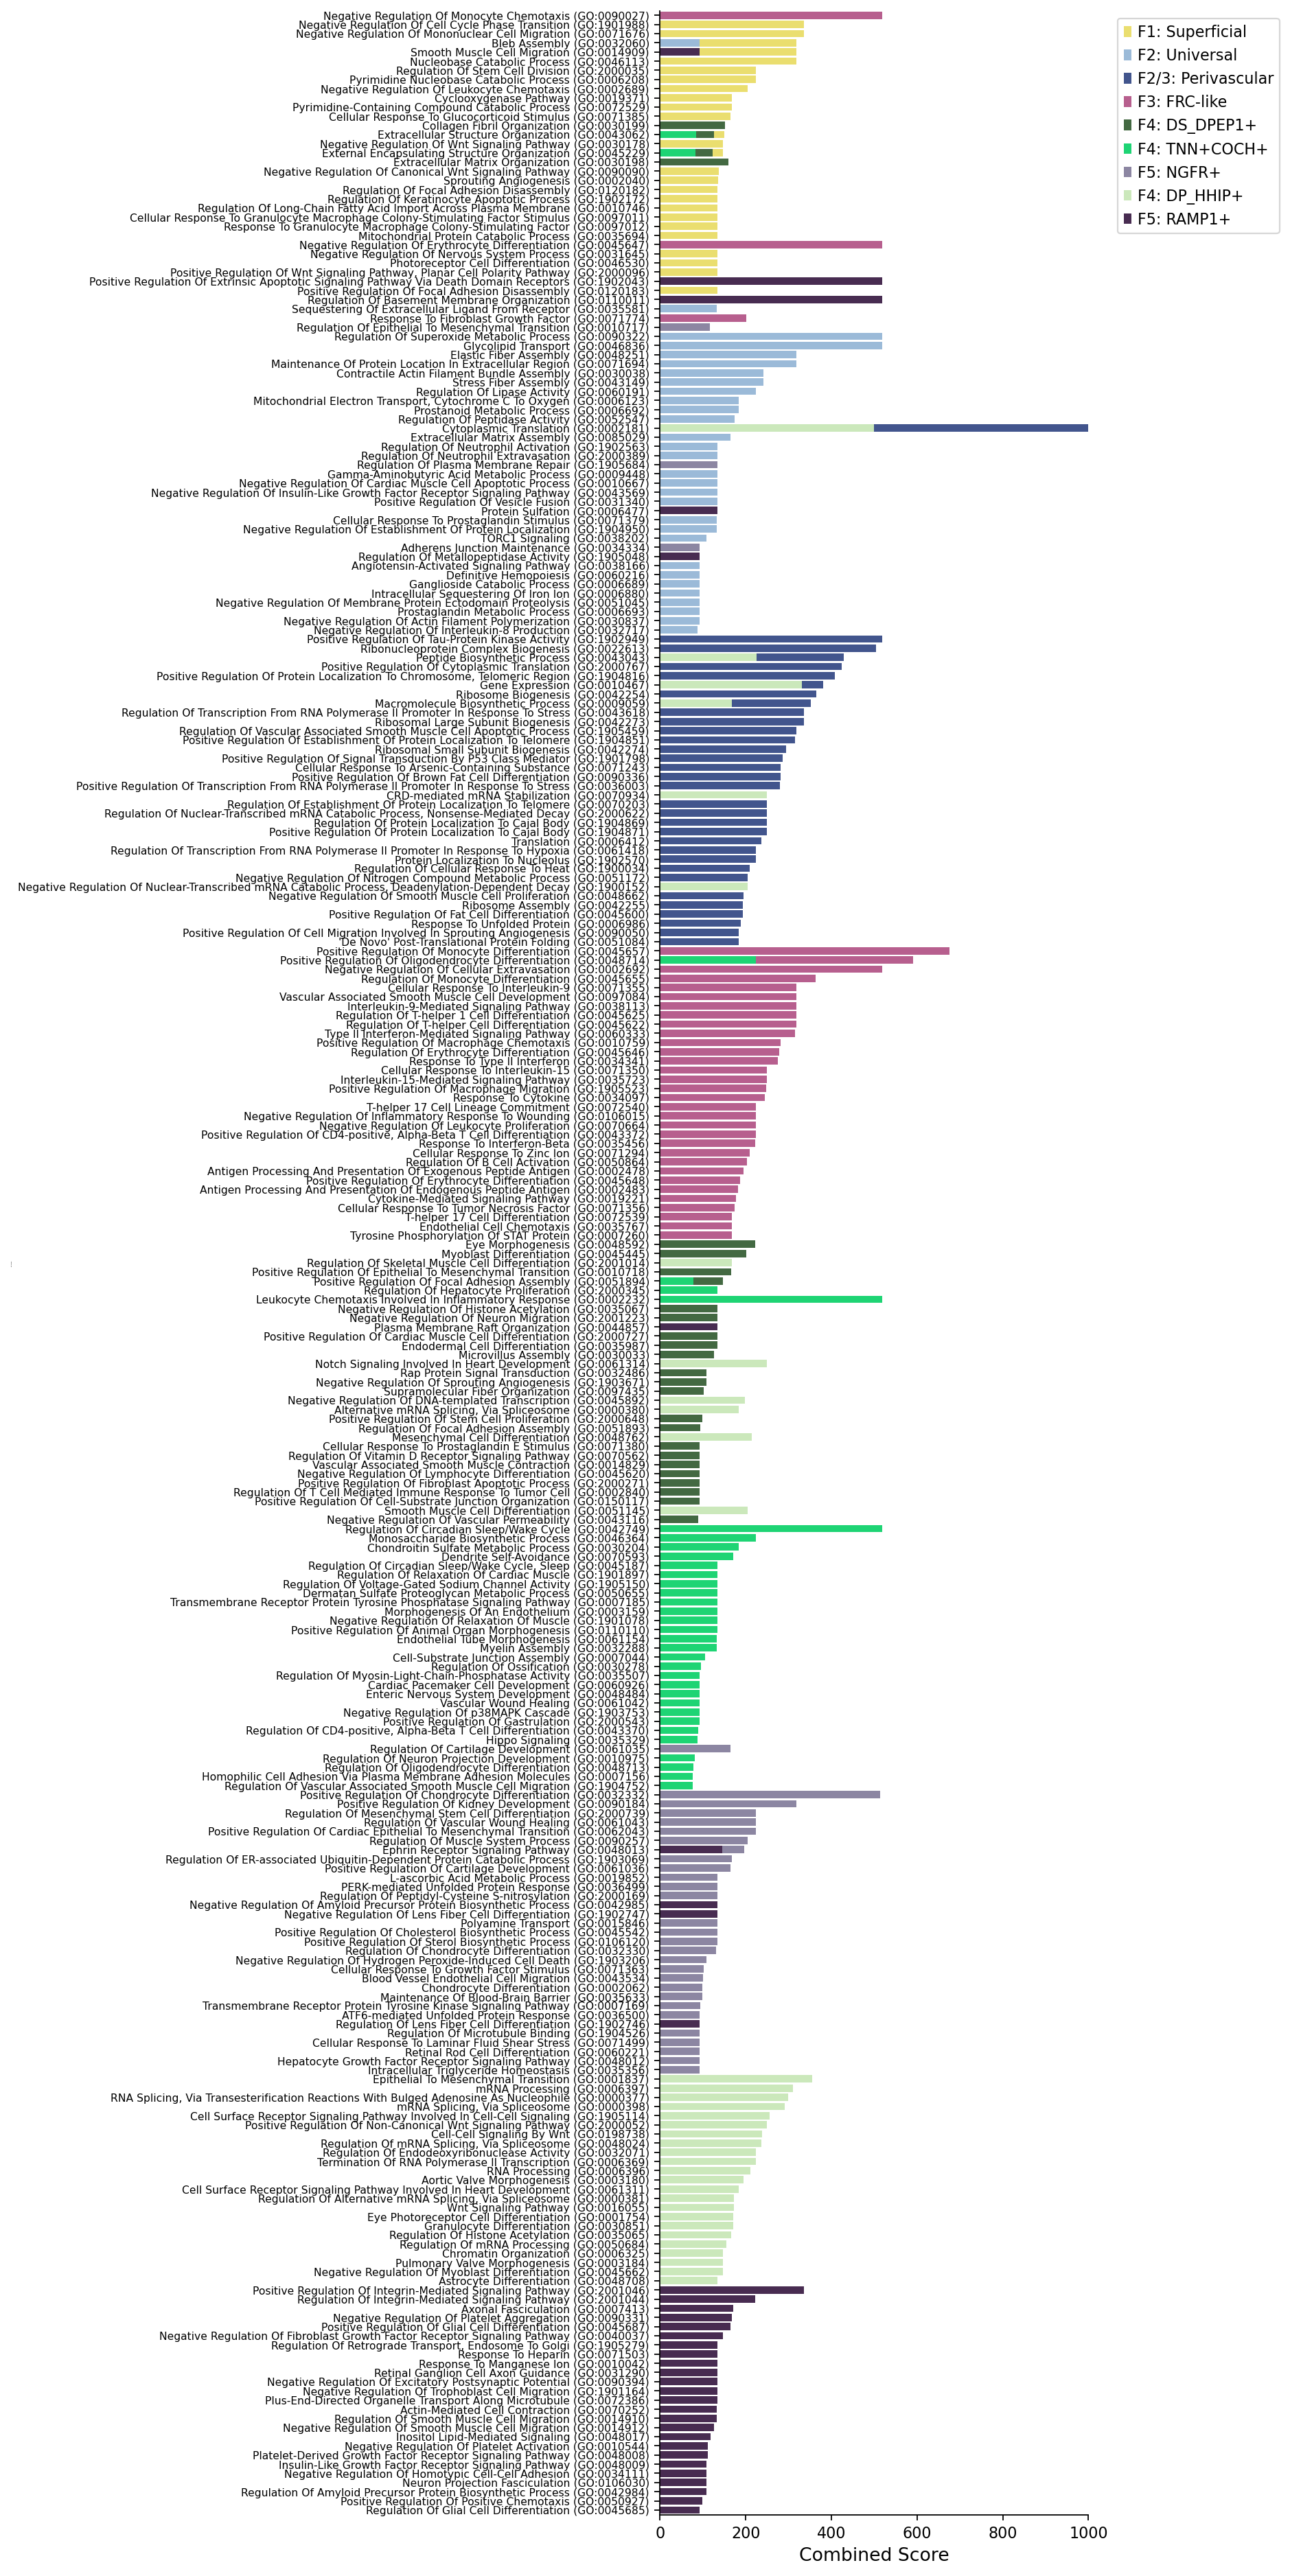

In [15]:
PLOTTING_VALUE = 'Combined Score'

top_gsea_df = gsea_df.groupby('Cluster').apply(lambda x: x.nlargest(35, PLOTTING_VALUE)).reset_index(drop=True)

top_gsea_df['Cluster'] = pd.Categorical(top_gsea_df['Cluster'], categories=ORDER, ordered=True)
top_gsea_df = top_gsea_df.sort_values(by=['Cluster', PLOTTING_VALUE], ascending=[True, False])
cluster_colors = top_gsea_df['Cluster'].map(color_palettes)

plt.figure(figsize=(5, 30))
sns.barplot(
    x=PLOTTING_VALUE, y='Term', hue='Cluster',
    data=top_gsea_df, palette=color_palettes, dodge=False
)

plt.title('', fontsize=14)
plt.xlabel(PLOTTING_VALUE, fontsize=12)
plt.ylabel('Pathway', fontsize=0)
plt.xticks(fontsize=10)
plt.yticks(fontsize=7)
plt.xlim(right=1000)
sns.despine(top=True, right=True)
plt.grid(False)

handles, labels = plt.gca().get_legend_handles_labels()
ordered_handles = [handles[labels.index(c)] for c in ORDER if c in labels]
plt.legend(ordered_handles, ORDER, title='', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize='13')

plt.tight_layout()
#plt.savefig("sfig2/gsea_healthy.pdf", dpi=300)
plt.show()




In [16]:
group1_clusters = [
    'F1: Superficial',
    'F2: Universal',
    'F2/3: Perivascular',
    'F3: FRC-like'
]

group2_clusters = [
    'F4: DS_DPEP1+',
    'F4: TNN+COCH+',
    'F5: NGFR+',
    'F4: DP_HHIP+',
    'F5: RAMP1+'
]

def plot_gsea_cluster_group(df, clusters, filename, color_palette, plotting_value='Combined Score'):
    filtered_df = df[df['Cluster'].isin(clusters)].copy()
    filtered_df['Cluster'] = pd.Categorical(filtered_df['Cluster'], categories=clusters, ordered=True)
    filtered_df = filtered_df.sort_values(by=['Cluster', plotting_value], ascending=[True, False])
    
    plt.figure(figsize=(3, 30))
    sns.barplot(
        x=plotting_value, y='Term', hue='Cluster',
        data=filtered_df, palette=color_palette, dodge=False
    )

    plt.title('', fontsize=14)
    plt.xlabel(plotting_value, fontsize=12)
    plt.ylabel('Pathway', fontsize=0)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlim(right=1000)
    sns.despine(top=True, right=True)
    plt.grid(False)

    handles, labels = plt.gca().get_legend_handles_labels()
    ordered_handles = [handles[labels.index(c)] for c in clusters if c in labels]
    plt.legend(ordered_handles, clusters, title='', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize='13')

    plt.tight_layout()
    plt.savefig("sfig2/gsea_healthy1.pdf", dpi=300, bbox_inches="tight", format="pdf")
    plt.show()

/tmp/ipykernel_19142/1679565267.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


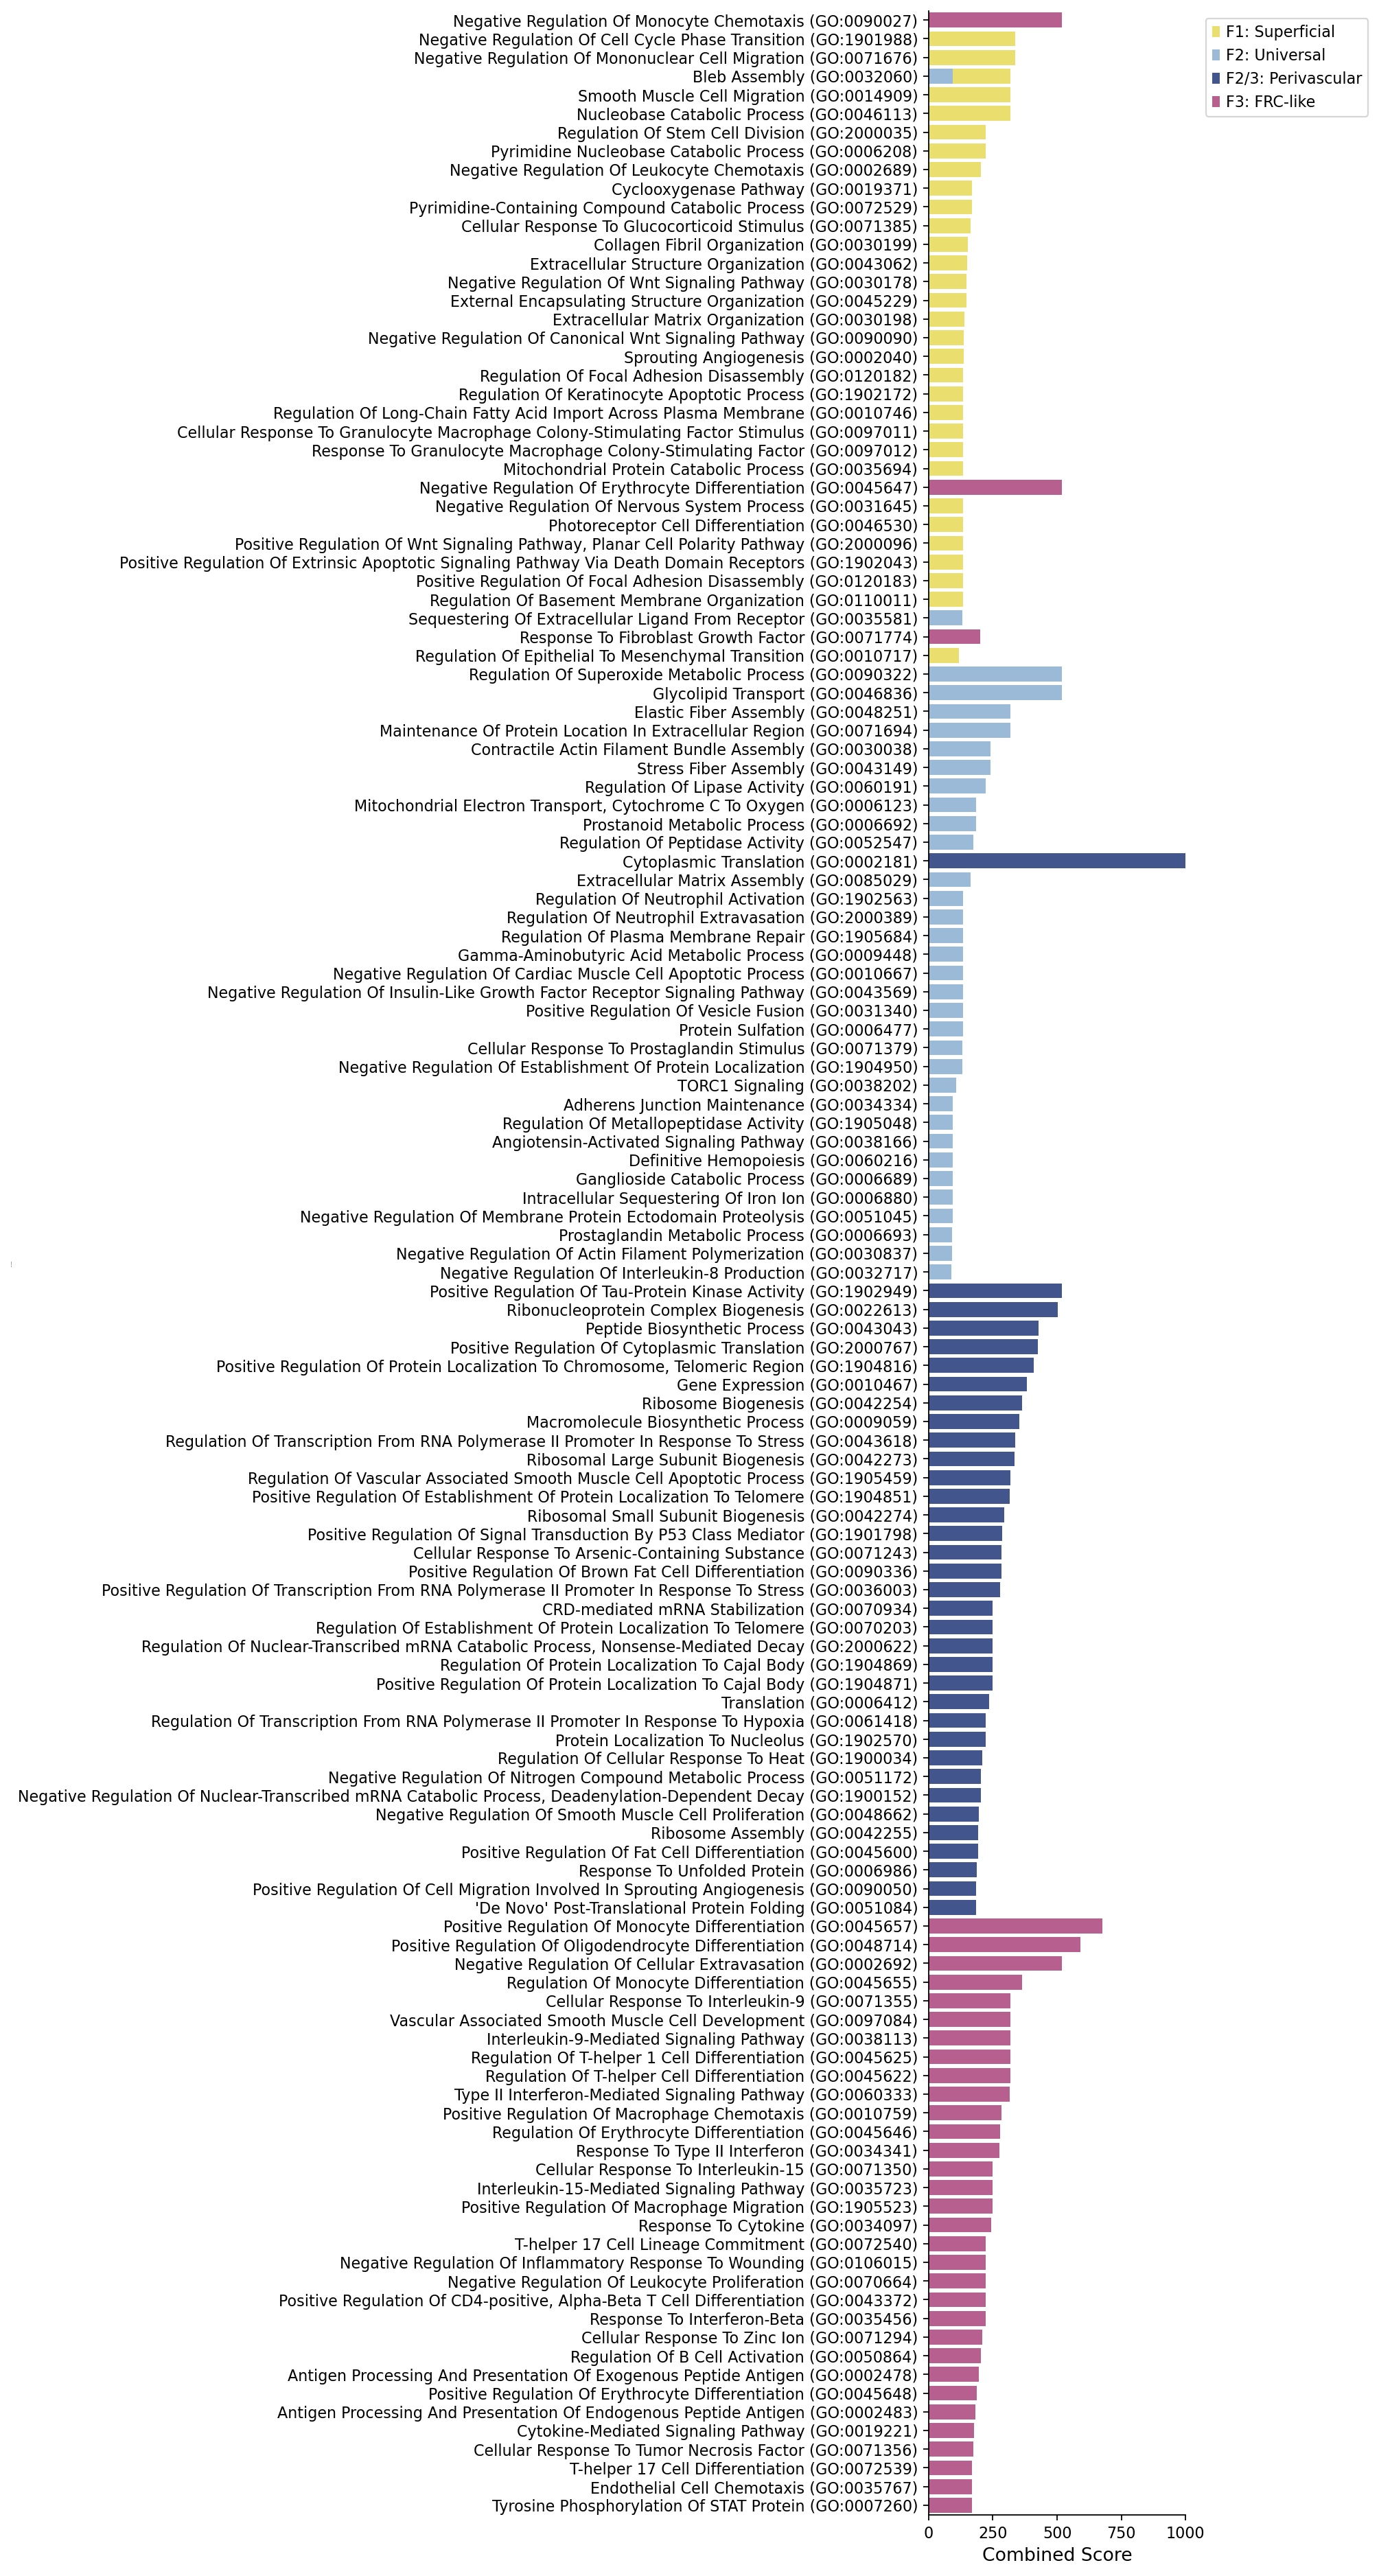

In [17]:
plot_gsea_cluster_group(top_gsea_df, group1_clusters, "sfig2/gsea_group1.pdf", color_palettes)

/tmp/ipykernel_19142/3117270282.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_gsea_df = gsea_df.groupby('Cluster').apply(lambda x: x.nlargest(20, PLOTTING_VALUE)).reset_index(drop=True)
/tmp/ipykernel_19142/3117270282.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


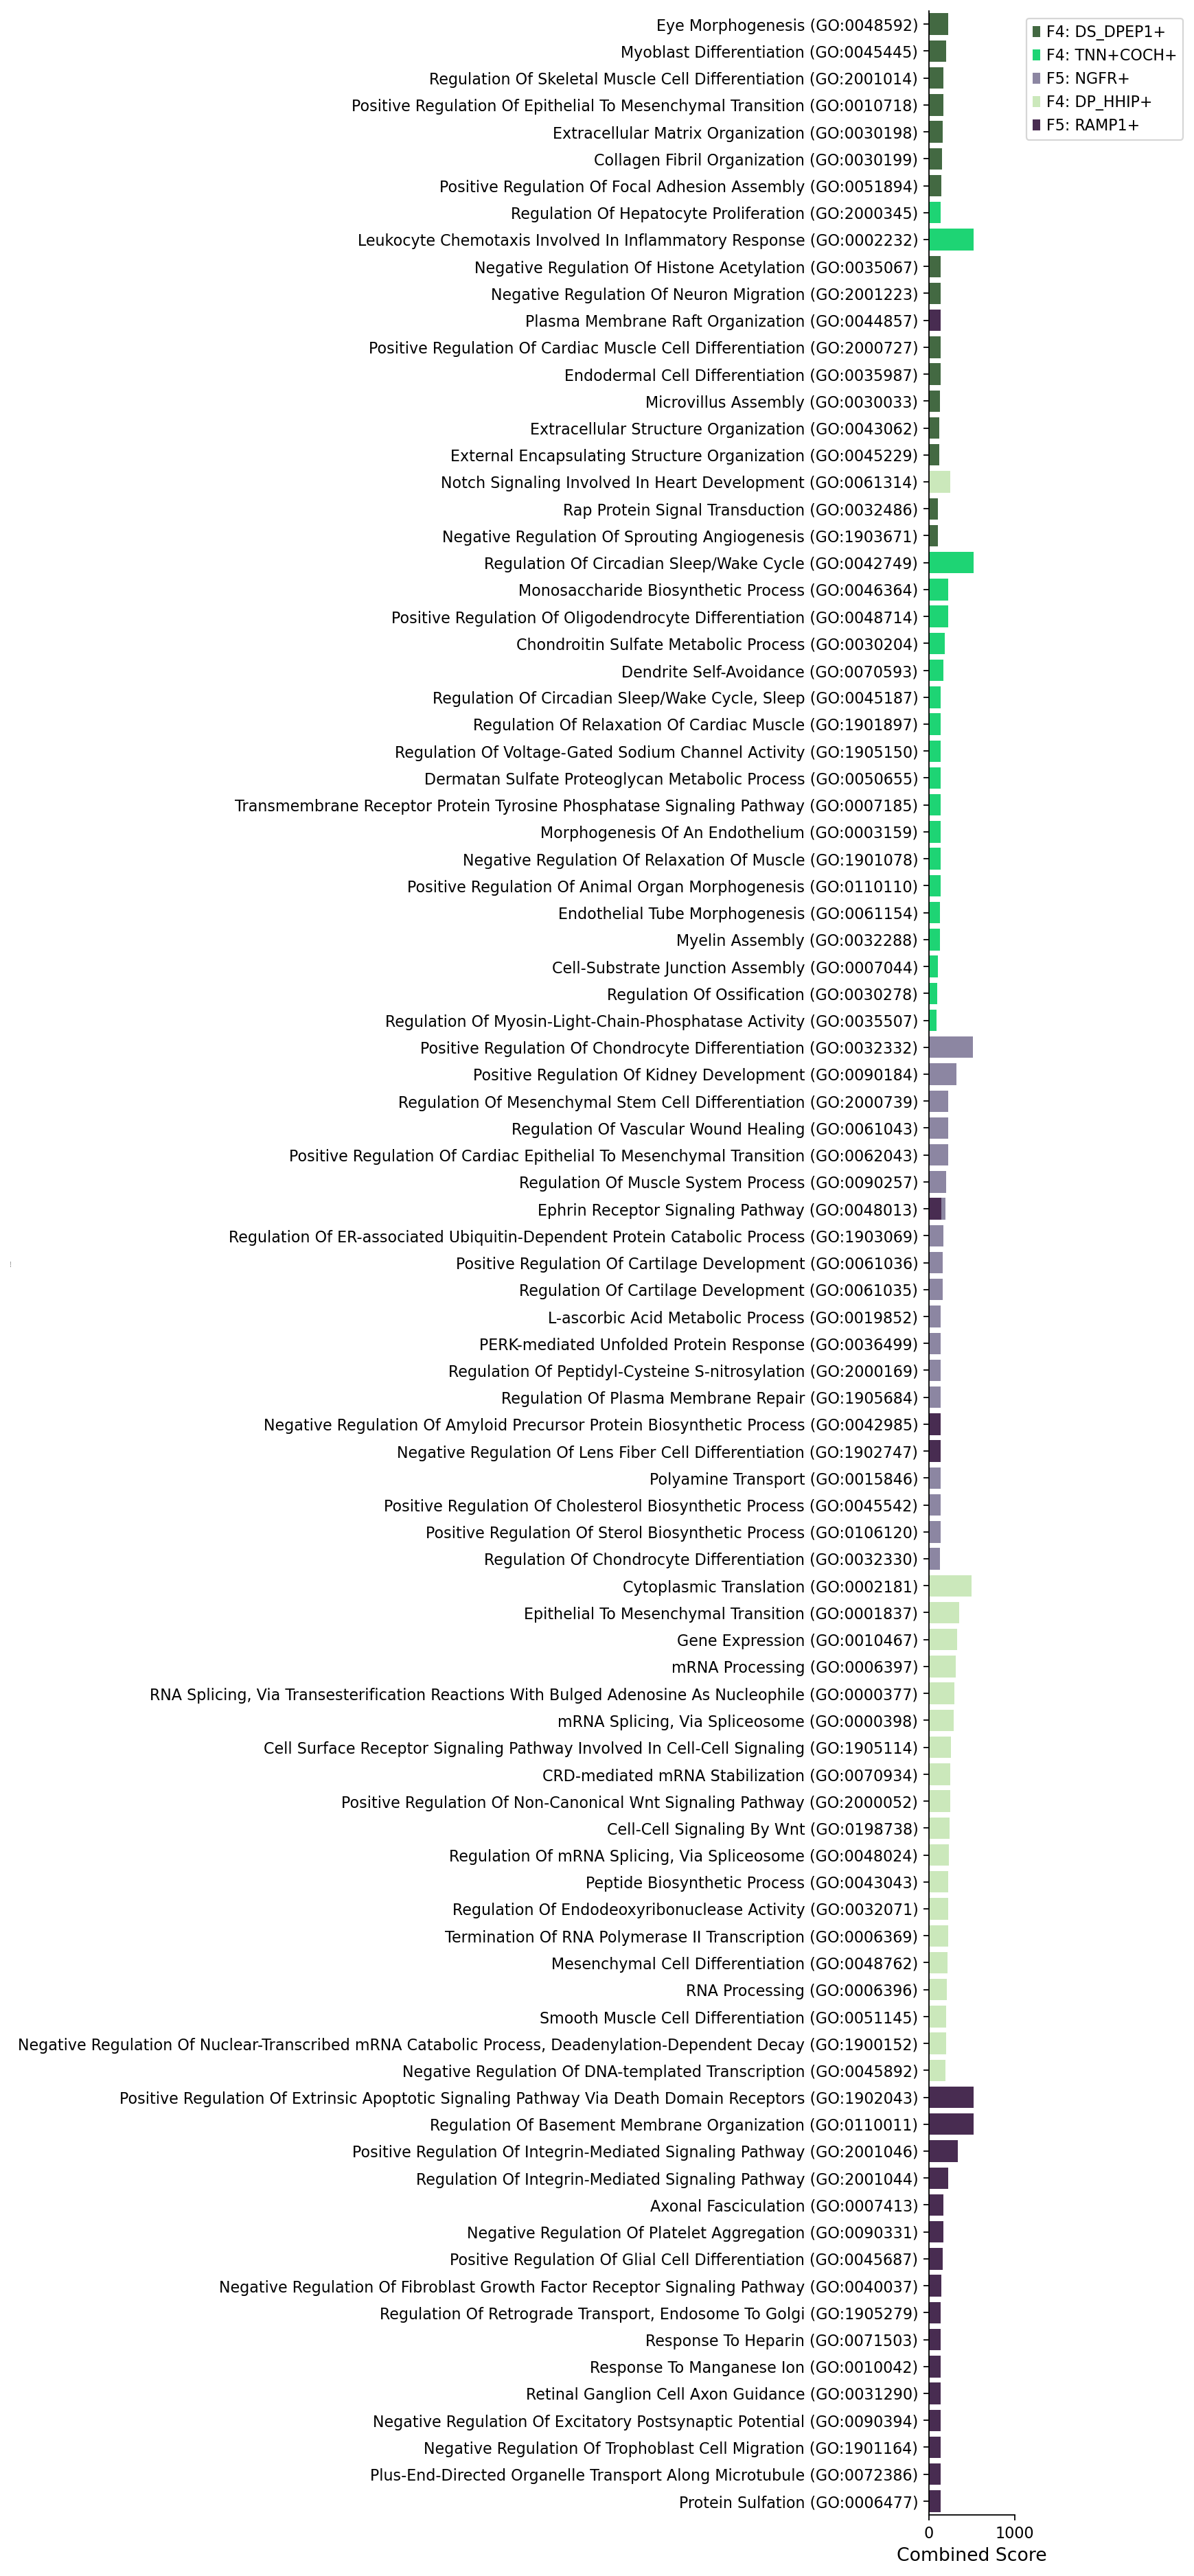

In [18]:
top_gsea_df = gsea_df.groupby('Cluster').apply(lambda x: x.nlargest(20, PLOTTING_VALUE)).reset_index(drop=True)
top_gsea_df['Cluster'] = pd.Categorical(top_gsea_df['Cluster'], categories=ORDER, ordered=True)
top_gsea_df = top_gsea_df.sort_values(by=['Cluster', PLOTTING_VALUE], ascending=[True, False])

def plot_gsea_cluster_group(df, clusters, filename, color_palette, plotting_value='Combined Score'):
    filtered_df = df[df['Cluster'].isin(clusters)].copy()
    filtered_df['Cluster'] = pd.Categorical(filtered_df['Cluster'], categories=clusters, ordered=True)
    filtered_df = filtered_df.sort_values(by=['Cluster', plotting_value], ascending=[True, False])
    
    plt.figure(figsize=(1, 30))
    sns.barplot(
        x=plotting_value, y='Term', hue='Cluster',
        data=filtered_df, palette=color_palette, dodge=False
    )

    plt.title('', fontsize=14)
    plt.xlabel(plotting_value, fontsize=12)
    plt.ylabel('Pathway', fontsize=0)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlim(right=1000)
    sns.despine(top=True, right=True)
    plt.grid(False)

    handles, labels = plt.gca().get_legend_handles_labels()
    ordered_handles = [handles[labels.index(c)] for c in clusters if c in labels]
    plt.legend(ordered_handles, clusters, title='', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize='13')

    plt.tight_layout()
    plt.savefig("sfig2/gsea_healthy2.pdf", dpi=300,bbox_inches="tight", format="pdf")

    plt.show()
    
    
plot_gsea_cluster_group(top_gsea_df, group2_clusters, "sfig2/gsea_group2.pdf", color_palettes)

# TRANSCRIPTION FACTOR

In [19]:
sc.settings.verbosity=0 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, dpi_save = 300, facecolor="white", frameon=False, figsize=(4,4))

sc.settings.figdir = "sfig2"


In [20]:
net = dc.get_collectri(organism='human', split_complexes=False)
net

source          target  weight  \
0         MYC            TERT       1   
1        SPI1           BGLAP       1   
2       SMAD3             JUN       1   
3       SMAD4             JUN       1   
4      STAT5A             IL2       1   
...       ...             ...     ...   
43173    NFKB  hsa-miR-143-3p       1   
43174     AP1     hsa-miR-206       1   
43175    NFKB   hsa-miR-21-5p       1   
43176    NFKB  hsa-miR-224-5p       1   
43177     AP1     hsa-miR-144       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                      10022869;12374795  
3                                      10022869;12374795  
4      10022878;11435608;17182565;17911616;22854263;2...  
...                                                  ...  
43173                                           19472311  
43174                                           19721712  
43175                                  20813833;22387281  
43176                                  23474441;23988648  
43177                                           23546882  

[43178 rows x 4 columns]

In [21]:
adata.X[:6,:6].A

array([[0.        , 0.        , 0.51248444, 0.51248444, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.91178454, 0.        , 0.        ,
        0.        ],
       [0.58537907, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.39431788, 0.        , 0.39431788, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [22]:
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)


In [23]:
sc.pp.highly_variable_genes(adata,  
                                n_top_genes=6000, 
                                subset=True,
                                batch_key="DonorID",
                                check_values=False,
                                #layer="normalized"
                               ) #100

In [24]:
adata.raw = ad.AnnData(adata.layers["counts"].copy(), var=adata.var.copy(), obs=adata.obs.copy())
#get_collectri
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

Running ulm on mat with 165649 samples and 6000 targets for 521 sources.


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


In [25]:
adata.obsm['collectri_ulm_estimate'] = adata.obsm['ulm_estimate'].copy()
adata.obsm['collectri_ulm_pvals'] = adata.obsm['ulm_pvals'].copy()

acts = dc.get_acts(adata, obsm_key='ulm_estimate')
acts




AnnData object with n_obs × n_vars = 165649 × 521
    obs: 'sample_id', 'barcode', 'dataset_id', 'GSE', 'Site_status', 'Patient_status', 'DonorID', 'Location', 'Age', 'Sex', 'n_genes', 'OriginalAnnotation', 'Chemistry', 'lvl3_annotation', 'lvl2_annotation', 'lvl1_annotation', 'lvl0_annotation', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'QC_hi', 'QC_mid', 'leiden_res0.2', 'Site_status_binary', 'atlas_status_reynolds', 'atlas_status', 'Site_status2', 'Patient_status2', 'Sex_original', 'fb_vs_other', 'fb_vs_other2', 'core', 'fbs_pericytes_other', 'leiden_res1', 'leiden_res1.5', 'old_annotation', 'test', 'fbs', 'fbs2', 'fbs3', 'new_annotation3', 'new_annotation2', 'new_annotation1', 'new_annotation00', 'fb_status_figs', 'Location_original', 'Location_broad', 'Location_detailed', 'leiden_res0.5', 'te

In [26]:
# sc.pl.umap(acts, color=['KLF5', 'corefb_names2'], cmap='RdBu_r', vcenter=0)
# sc.pl.violin(acts, keys=['KLF5'], groupby='corefb_names2', rotation=90)


In [27]:
df= dc.rank_sources_groups(acts, groupby='corefb_names2', reference='rest', method='t-test_overestim_var')
df
n_markers = 5
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'F1: Superficial': ['PITX2', 'SMAD3', 'RUNX2', 'POU2F2', 'PAX6'],
 'F2/3: Perivascular': ['APEX1', 'CEBPA', 'FLI1', 'ATF4', 'RFX5'],
 'F2: Universal': ['ZFPM2', 'SPIB', 'KLF5', 'SKIL', 'FOSL1'],
 'F3: FRC-like': ['NFKB1', 'NR1H3', 'NFKB', 'RELB', 'RELA'],
 'F4: DP_HHIP+': ['GSC', 'GRHL3', 'FOXH1', 'NKX3-2', 'HOXA13'],
 'F4: DS_DPEP1+': ['FOXH1', 'NFATC1', 'TCF7', 'NR4A2', 'MEF2A'],
 'F4: TNN+COCH+': ['IRF8', 'ZNF382', 'MYF5', 'MYOD1', 'HLX'],
 'F5: NGFR+': ['TP63', 'APEX1', 'TP73', 'CTNNB1', 'NR5A1'],
 'F5: RAMP1+': ['PDX1', 'TP73', 'BARX2', 'TBX2', 'CIITA']}

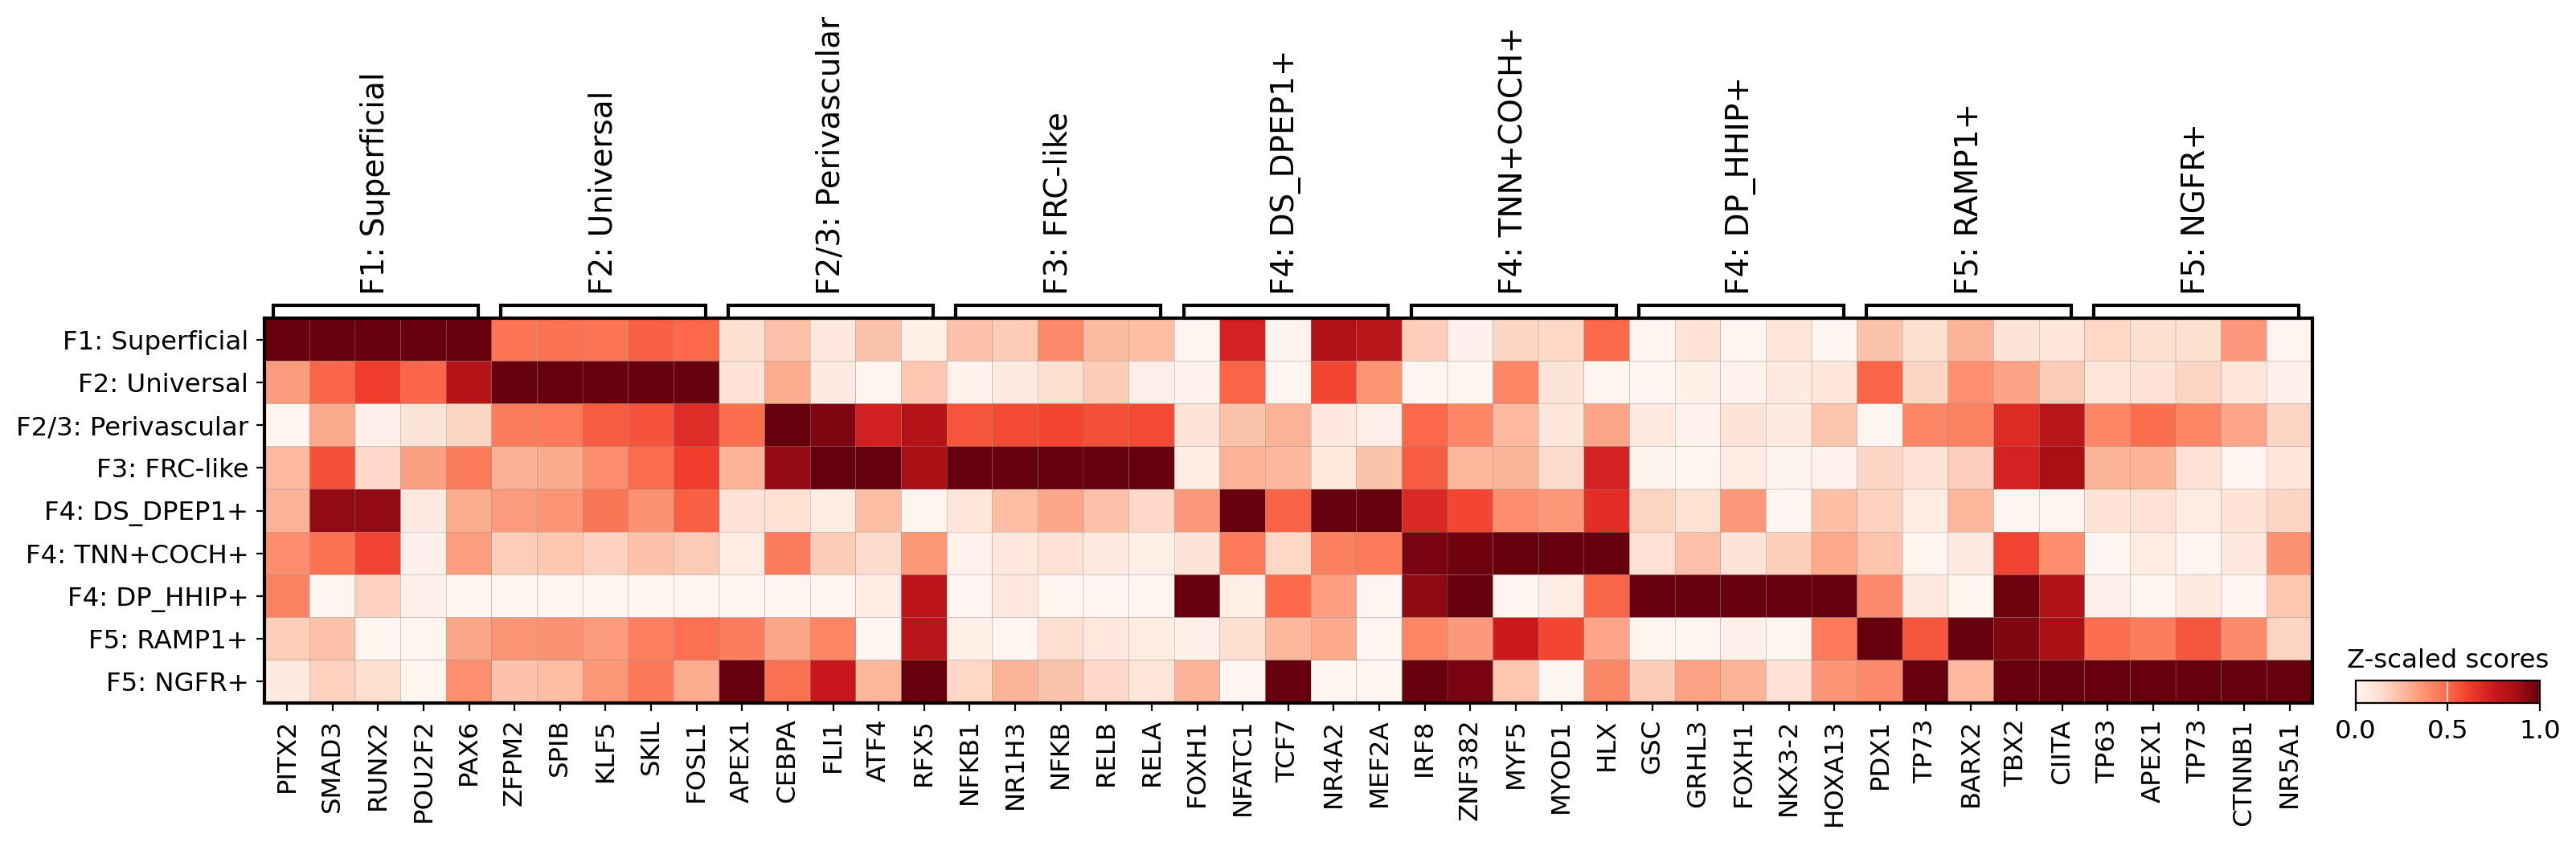

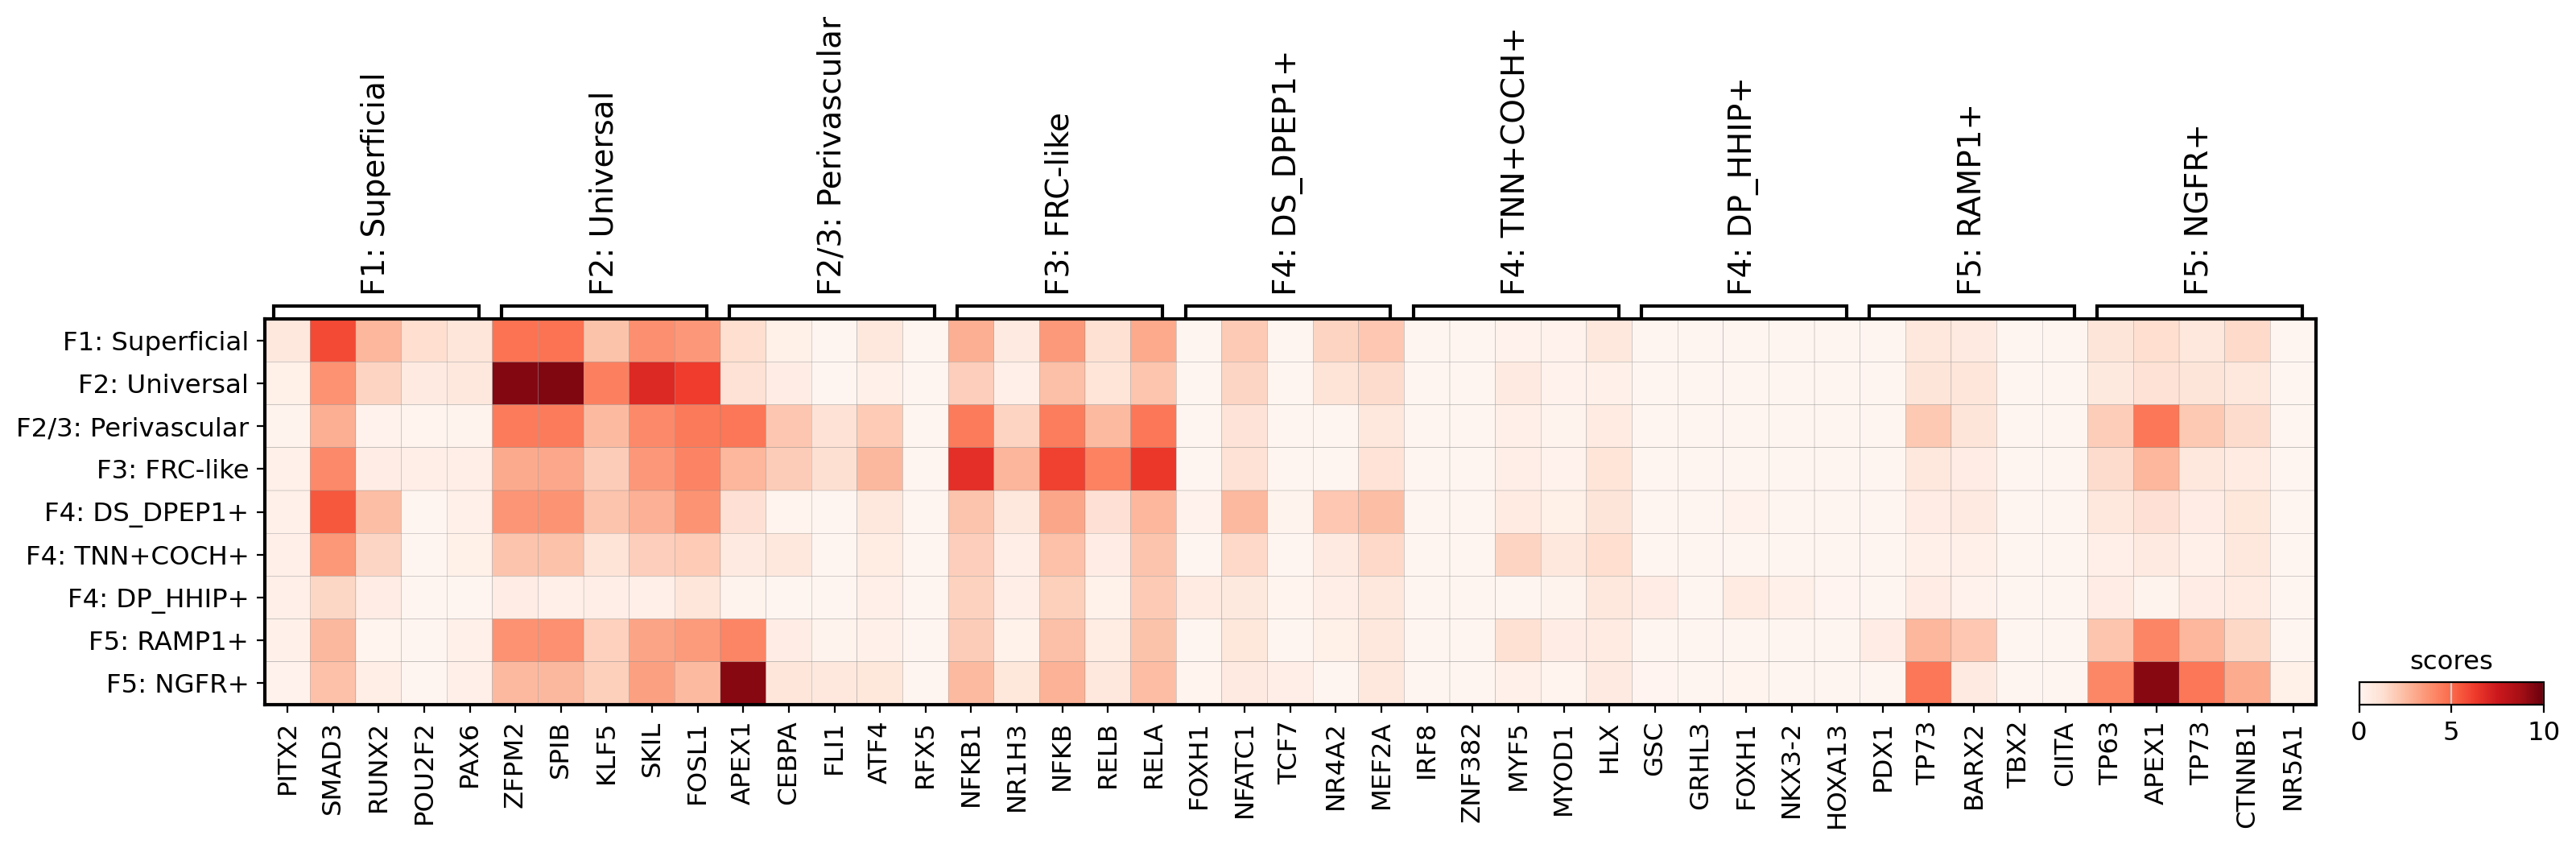

In [30]:

ORDER=['F1: Superficial',
 'F2: Universal',
        'F2/3: Perivascular',
 'F3: FRC-like',
 'F4: DS_DPEP1+',
 'F4: TNN+COCH+',
 'F4: DP_HHIP+', 'F5: RAMP1+',
 'F5: NGFR+',


      ]
source_markers = {key: source_markers[key] for key in ORDER if key in source_markers}



acts.obs['corefb_names2'] = pd.Categorical(acts.obs['corefb_names2'], categories=ORDER, ordered=True)

sc.pl.matrixplot(
    acts, source_markers, 'corefb_names2', 
    dendrogram=False,  # Disable automatic reordering
    standard_scale='var', colorbar_title='Z-scaled scores', 
    cmap='Reds', categories_order=ORDER,
    save="tf1.pdf"
)

sc.pl.matrixplot(
    acts, source_markers, 'corefb_names2', 
    dendrogram=False,  # Disable automatic reordering
    colorbar_title='scores', cmap='Reds', 
    categories_order=ORDER, vmax=10,vmin=-0,
    save="tf2.pdf"
)


In [29]:
sc.logging.print_versions()




-----
anndata     0.10.6
scanpy      1.9.8
-----
PIL                         9.5.0
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.14.0
backcall                    0.2.0
bottleneck                  1.3.7
certifi                     2023.07.22
cffi                        1.16.0
chardet                     5.2.0
charset_normalizer          3.1.0
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.0
cycler                      0.10.0
cython_runtime              NA
dask                        2024.2.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
decoupler                   1.6.0
defusedxml                  0.7.1
dill                        0.3.8
docrep                      0.3.